# Vocabulary Analysis

Man Ho Wong | April 12, 2022

*Jupyter notebooks are not always rendered properly on Github. Please [view this notebook here on nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/vocabulary_analysis.ipynb) if that happens.*

# 1 Overview

> **Data processing and analysis:**  
>`data_curation.ipynb`  
>`data_preprocessing.ipynb`  
>`exploratory_analysis.ipynb`  
>`vocabulary_analysis.ipynb`  <-- You are here

## 1.1 Objectives


### Table of contents

1. Overview
    - 1.1 Objectives
    - 1.2 Quick recap
    - 1.3 Efficiency considerations

2. Semantic network: vocabulary analysis beyond mean length of utterance (MLU)
    - 2.1 Child vocabulary as a lexical semantic network
    - 2.2 Different metrics for word-to-word similarity
    - 2.3 Pipeline for constructing lexical semantic network

3. Semantic network analysis
    - 3.1 Characterizing semantic network
    - 3.2 Comparing children from different SES groups

### Script header

In [1]:
# Python libraries and packages required
from collections import Counter
from gensim.models.keyedvectors import KeyedVectors  # For using word vectors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint                          # For pretty printing
import pylangacq                       # For reading CHAT files
import nltk
import networkx as nx                  # For contructing and analyzing networks
from sklearn import metrics as skm     # For pairwise cosine similarity
from sklearn.decomposition import PCA  # For dimention reduction

# Unpickle data
data_idx = pickle.load(open('../data/childes/data_idx_processed.pkl', 'rb'))

# Pretty printing for better readability
# With this, you can print dict in compact format instead of one item
#   per line. Items will be in alphabetical order. Nested Dict will be printed 
#   with suitable indentation. It will also print Counter in descending order.
#   To use this, call cp.pprint()
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# Function to get all labels of a given variable (e.g. 'mot_edu')
def get_labels(var):
    labels_by_corpus = {}
    corpus_set = set(data_idx.corpus)
    for c in corpus_set:
        labels_by_corpus[c] = set(data_idx[var][data_idx.corpus==c])
    return labels_by_corpus

data_idx.head()

,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
0,../data/childes/Bates/Free20/amy.cha,Bates,NaN,"{CHI, MOT}",Target_Child,Bates_Target_Child,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
1,../data/childes/Bates/Free20/betty.cha,Bates,NaN,"{CHI, MOT}",Betty,Bates_Betty,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
2,../data/childes/Bates/Free20/chuck.cha,Bates,NaN,"{CHI, MOT}",Chuck,Bates_Chuck,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
3,../data/childes/Bates/Free20/doug.cha,Bates,NaN,"{CHI, MOT}",Doug,Bates_Doug,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
4,../data/childes/Bates/Free20/ed.cha,Bates,NaN,"{CHI, MOT}",Ed,Bates_Ed,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"


In [2]:
ses_list = ['UC', 'MC', 'WC']
paths_ses = {}
readers_ses = {}

# read CHAT files into separate readers according to SES 
print('Reading CHAT files...')
for s in ses_list:
    paths_ses[s] = data_idx[(data_idx.ses == s) & 
                        (data_idx.age_m>=20) & 
                        (data_idx.age_m<=42)].file_path
    readers_ses[s] = pylangacq.Reader.from_files(paths_ses[s])

print('Done!')

Reading CHAT files...
Done!


---

# 2 Semantic network: vocabulary analysis beyond mean length of utterance (MLU)


## 2.1 Child vocabulary as a lexical semantic network

Why

References

## 2.2 Different metrics for word-to-word similarity

Relationship between words in a lexicon can be represented by how similar they are in their semantic meanings. There are many metrics to measure word-to-word similarity. In general, these metrics can be derived from two different sources: human-annotated datasets (e.g. WordNet), or word associations learned by machine algorithms (e.g. word2vec). Both sources have their pros and cons for different applications. In this project, I will use machine-generated word associations for the calculation of word-to-word similarity because it is more flexible (e.g. getting different word associations by using different training data) than human-annotated datasets and is probably less prone to human biases (depending on training data). Besides, human-annotated datasets are based on formal taxonomies of words and such knowledge is unlikely to be present in a young child's world.

There are two main types of machine-learning models to generate word associations, count-based and prediction-based models. In this project, word similarity will be computed from word embeddings based on a semantic network called **ConceptNet**, which is a network built by both count-based and prediction-based models. The most unique feature about ConceptNet is that, unlike other semantic networks, it is concept-based rather than word-based (though nodes are still represented by words or phrases). For mapping word relations in a young child's lexicon where word meanings are closely related to the concepts that they are acquiring at the same time, this concept-based feature probably makes ConceptNet more suitable for this project than word embeddings derived from other models.

## 2.3 Pipeline for constructing lexical semantic network

In this section, I will develop a pipeline for constructing lexical semantic network from each participant's word list in each CHAT file. This pipeline will be applied to all CHAT files in the dataset later. Below are the general steps:
1. Extract tokens from a CHAT file
2. Import ConceptNet-Numberbatch word vectors
3. Map each word in the word list to its word vector
4. Compute pairwise word similarity (cosine similarity) from word vectors
5. Construct a semantic network using cosine similarities as the weights of edges

### Step 1: Extract tokens from a CHAT file
I will use a CHAT file from the Brown Corpus to develop the pipeline, but instead of "Adam" I am going to use a file from "Eve" for a change. To streamline the process, I created a simple function, `get_vocab`, which allows me to get a `set` of unique words from a CHAT file with the option to specify word classes. This function can be accessed from `etc.pittchat` like other custom functions in this project.

In [3]:
# Read 'Eve' in Brown corpus into a reader object
path = '../data_samples/childes/Brown.zip'
eve = pylangacq.Reader.from_zip(path, 'Eve')

In [4]:
# Get word list from the 3rd CHAT file in 'eve'
from etc.pittchat import get_vocab as get_vocab
vocab = get_vocab(eve[2], pos='n')  # get nouns only
cp.pprint(vocab)

{'arm', 'back', 'bacon', 'ball', 'banana', 'book', 'bowl', 'box', 'butter',
 'carrot', 'celery', 'cheese', 'coat', 'coffee', 'cracker', 'cup', 'dog',
 'door', 'drink', 'drop', 'feet', 'gopher', 'grahamcracker', 'grape', 'help',
 'hill', 'home', 'horse', 'horsie', 'juice', 'lady', 'lap', 'man', 'minute',
 'mommy', 'napkin', 'page', 'paper', 'pencil', 'picture', 'play', 'pudding',
 'right', 'self', 'shoe', 'soup', 'spoon', 'stool', 'sugar', 'swim', 'table',
 'tapioca', 'teddybear', 'toe', 'toy', 'train'}


I am extracting words here instead of morphemes because morphemes are annotated by adults and they do not necessarily represent lexical relationships in the child's mind. For example, the meaning of 'teddybear' is not necessarily 'Teddy' (name of Theodore Roosevelt Jr.) and 'bear' (an animal) combined, but a concept of its own and could even be unrelated to 'Teddy' and 'bear' in the child's world knowledge.

### Step 2: Import ConceptNet-Numberbatch word vectors

Before further processing, we will need to generate word vectors by training models on text data. Due to time constraints and computing resources, I will not not train my own model to get the word vectors. Instead, I will use a pre-trained dataset, ConceptNet-Numberbatch, to get the word vectors. It can be download from their official GitHub. The following code will use the Gensim package for processing word vectors.

In [ ]:
# Download and extract ConceptNet-Numberbatch to your local drive, and run the
##   following code to import the word vectors

# from gensim.models.keyedvectors import KeyedVectors
wordvec = KeyedVectors.load_word2vec_format('C:\Users\manho\gensim-data\conceptnet-numberbatch-19.08\numberbatch-en.txt')

# Save the word vectors in gensim's native format for efficiency
wordvec.save('../data/conceptnet/numberbatch-en.kv')

In [5]:
# load word vectors from file
wordvec = KeyedVectors.load('../data/conceptnet/numberbatch-en.kv', mmap='r')

### Step 3: Map each word in the word list to its word vector

A child may produce "words" that not found in their native language as creating new words are very common among young children. Such words may not be found in ConceptNet and this may generate errors. This is generally referred as an out-of-vocabulary (OOV) problem. To handle these words, I will simply remove them from the list for now, although we probably need to develop a better strategy to handle OOV words later when possible.

In [6]:
# Remove out-of-vocabulary words
vocab = [w for w in vocab if wordvec.has_index_for(w)]

# Map each word to its word vector in wordvec
vocab_wv = wordvec[vocab]

The resulting array, `vocab_wv`, contains one word vector in each row and each vector has 300 dimensions:

In [7]:
pd.DataFrame(vocab_wv, index=vocab).head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
swim,-0.0215,-0.0143,0.1220,0.1090,0.0097,-0.0050,-0.1168,0.0073,0.1763,0.0347,...,0.0507,-0.0278,-0.0182,-0.0004,0.0120,-0.0488,0.0120,0.0015,-0.0073,0.0187
back,-0.0696,-0.1026,0.0715,0.1850,0.0106,-0.0777,-0.1391,-0.0001,0.1149,-0.0082,...,-0.0145,-0.0318,0.0727,-0.0028,0.0388,0.0221,0.0229,-0.0571,0.0642,-0.0131
cracker,0.0099,0.0323,0.2113,0.0265,-0.0112,0.0419,0.1295,-0.1105,-0.0848,-0.0627,...,0.0048,-0.0049,-0.0360,0.0477,-0.0297,-0.0305,0.0129,0.0571,0.0309,-0.0174
horsie,-0.0020,-0.0308,0.1955,-0.0434,-0.0996,-0.0230,-0.0736,-0.0505,0.0091,0.0262,...,0.0354,-0.0305,0.0317,-0.0400,-0.0236,-0.0551,0.0052,-0.0041,-0.0292,-0.0667
cheese,0.0878,0.0801,0.1972,0.0120,0.0984,0.1169,0.1852,-0.1394,0.0343,-0.0884,...,-0.0161,0.0479,-0.0012,0.0260,-0.0499,-0.0429,0.0567,0.0097,0.0010,0.0175


For data inspection, the dimensions of the vectors can be reduced from 300 to 3 by principle component analysis (PCA). The resulting components can be visualized with a 3-D scatter plot:

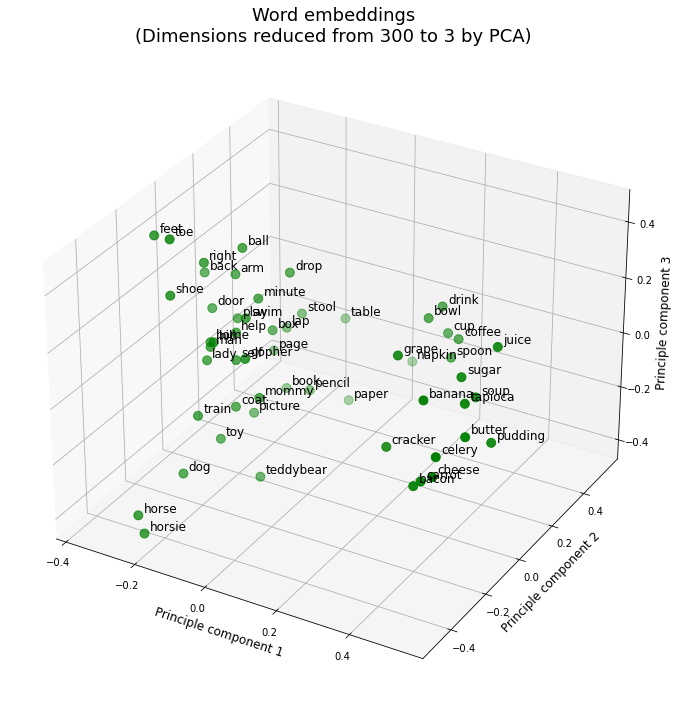

In [31]:
# Reduce dimension from 300 to 3 by PCA
pca = PCA(n_components=3)
result = pca.fit_transform(vocab_wv)

# Copy data for each dimension
X = result[:,0]
Y = result[:,1]
Z = result[:,2]

# Create figure with a 3D axis object
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

# 3D scatter plot
ax.scatter(X, Y, Z, facecolors='green', s=80)

# Add word labels
for x, y, z, word in zip(X, Y, Z, vocab):
    ax.text(x+0.01, y+0.01, z+0.01, word, size='12')
    
# Set axis labels and title
ax.set_xlabel('Principle component 1', size='12')
ax.set_ylabel('Principle component 2', size='12')
ax.set_zlabel('Principle component 3', size='12')
ax.set_title('Word embeddings\n(Dimensions reduced from 300 to 3 by PCA)',size='18')
ax.grid(color='black')
plt.show()

### Step 4: Compute pairwise word similarity (cosine similarity) from word vectors

To construct a semantic network, we need to know the word similarity between every possible pair of words. As far as I know, Gensim can only compute cosine similarity between a pair of words one at a time. To compute pairwise cosine similarities across the entire word list, one has to do this manually by iterating the cosine similarity function of Gensim. Fortunately, there is a Scikit-learn function called `pairwise.cosine_similarity`, which computes pairwise cosine similarity and generates a matrix of cosine similarities from word vectors:

In [8]:
# compute pairwise cosine similarities
# from sklearn import metrics as skm  # imported already in document header
vocab_sim = skm.pairwise.cosine_similarity(vocab_wv)

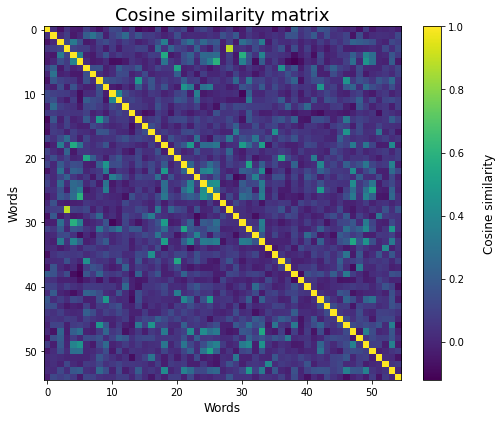

In [9]:
# Visualize the matrix of cosine similarities
plt.figure(figsize=(8,6.5))
plt.imshow(vocab_sim, aspect='auto', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('\nCosine similarity', size='12')
plt.xlabel('Words', size='12')
plt.ylabel('Words', size='12')
plt.title('Cosine similarity matrix', size='18')
plt.show()

### Step 5: Construct a semantic network using cosine similarities as the weights of edges

In a semantic network, words are the nodes and they can be linked by edges representing word similarity. There are many freely available tools to construct and analyze networks with nodes and edges. For this project, I chose to work with the NetworkX library because of its ease of use in Python and a large collection of algorithms for network analysis.  

In [10]:
# Create a NetworkX graph object
g = nx.Graph()

# Contruct the network from a word list and its similarity matrix
E = 0.19  # similarity threshold suggested in a child vocabulary study
for a, wordA in enumerate(vocab):
    for b, wordB in enumerate(vocab):
        # add an edge only when two words are different and similarity > E 
        if wordA != wordB and vocab_sim[a,b] > E:
            g.add_edge(wordA, wordB, weight=vocab_sim[a,b])
            
nx.info(g)

'Graph with 50 nodes and 168 edges'

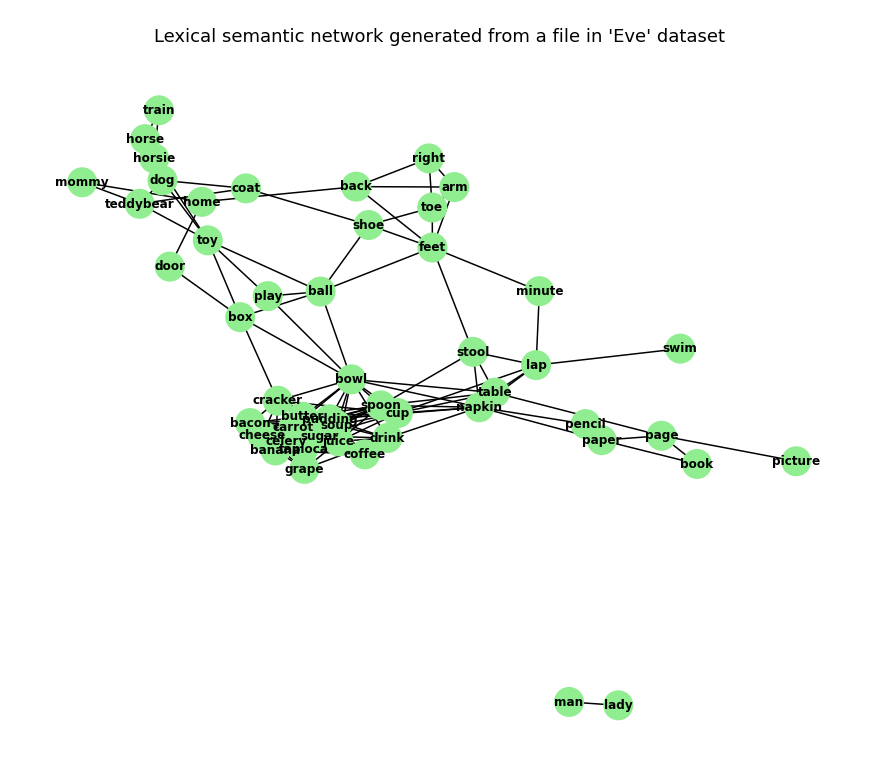

In [33]:
# Visualize the semantic netork built above
plt.figure(figsize=(12,10))
pos = nx.spring_layout(g, seed=0)
options = {
    "node_color": "lightgreen",
    "node_size": 900,
    "edge_color": "black",
    "width": 1.5,
    "edgecolors": "none",
    "font_color": "black",
    "font_weight": "bold",
    "font_size": "12"
}

nx.draw(g, pos, with_labels=True, **options)
plt.title("\nLexical semantic network generated from a file in 'Eve' dataset",
          size='18')
plt.show()

### Turning the above steps into a function

I will create a function for the above steps locally in this notebook because this will be the only document where the function will be used. Note that the function will not import the required Python packages nor the word vectors from ConceptNet-Numberbatch. They should be loaded separately before using the function.

In [32]:
def make_network(f_reader, pos='n', E=0.19):
    vocab = get_vocab(f_reader, pos=pos)  # Get word list    
    vocab = [w for w in vocab if wordvec.has_index_for(w)] # Remove OOV words
    vocab_wv = wordvec[vocab]  # Map each word to its word vector
    vocab_sim = skm.pairwise.cosine_similarity(vocab_wv)  # get cos similarity
    # Construct the network:
    g = nx.Graph()
    for a, wordA in enumerate(vocab):
        for b, wordB in enumerate(vocab):
            if wordA != wordB and vocab_sim[a,b] > E:
                g.add_edge(wordA, wordB, weight=vocab_sim[a,b])
    return g

# Test the function
g = make_network(eve[2])
nx.info(g)

'Graph with 50 nodes and 168 edges'

---

# 3 Semantic network analysis

## 3.1 Characterizing semantic network

In [13]:
# Number of nodes
g.number_of_nodes()

# Number of edges
g.number_of_edges()

# Average degree
degree_values = [v for k, v in g.degree()]
np.mean(degree_values)

# Average distance
for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
    nx.average_shortest_path_length(C)
p = dict(nx.shortest_path_length(g))

# Average local clustering coefficient
nx.average_clustering(g)

# all_pairs_node_connectivity
nx.all_pairs_node_connectivity(g)

# connected components
cp.pprint(list(nx.connected_components(g)))
nx.number_connected_components(g)

[{'arm', 'back', 'bacon', 'ball', 'banana', 'book', 'bowl', 'box', 'butter',
  'carrot', 'celery', 'cheese', 'coat', 'coffee', 'cracker', 'cup', 'dog',
  'door', 'drink', 'feet', 'grape', 'home', 'horse', 'horsie', 'juice', 'lap',
  'minute', 'mommy', 'napkin', 'page', 'paper', 'pencil', 'picture', 'play',
  'pudding', 'right', 'shoe', 'soup', 'spoon', 'stool', 'sugar', 'swim',
  'table', 'tapioca', 'teddybear', 'toe', 'toy', 'train'},
 {'lady', 'man'}]


2

In [ ]:
# More metrics

# diameter
# The function computes a lower bound on the diameter
#  (i.e., the maximum eccentricity) of a directed or undirected graph G.
# The procedure used varies depending on the graph being directed or not.
# nx.diameter(g)

# nx.average_degree_connectivity(g)
# nx.degree_centrality(g)

# Small-world-ness
# nx.sigma(g)

## 3.2 Comparing children from different SES groups